<a href="https://colab.research.google.com/github/heidaralavi/Gas-Prj/blob/main/Gas_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# گندله سازی اردکان
بررسی میزان مصرف گاز با برخی پارامترهای مهم

ابتدا توابع مورد نیاز را ایمپورت می کنیم

In [ ]:
!pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest,RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import scale , normalize, minmax_scale
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import xgboost as xgb

دریافت داده های اولیه

In [2]:
url = 'https://raw.githubusercontent.com/heidaralavi/Gas-Prj/main/total.csv'
df=pd.read_csv(url)
#df=pd.read_csv('input-data.csv')
df.head()

new_date  Moisture_600  ...  AN1_Zoon3_Temp(deg)  Gas_Consumption(Nm3)
0  2019-03-22      9.068056  ...           141.628364              196364.0
1  2019-03-23      8.997183  ...           145.570481              209304.0
2  2019-03-24      8.795833  ...           173.127236              206200.0
3  2019-03-25      8.850536  ...           179.281210              203772.0
4  2019-03-26      9.006061  ...           129.430960              200120.0

[5 rows x 20 columns]

حذف ستون تاریخ

In [3]:
df.drop(columns='new_date',inplace=True)

In [4]:
df.describe()

Moisture_600  ...  Gas_Consumption(Nm3)
count   1029.000000  ...           1029.000000
mean       9.069178  ...         177578.768707
std        0.201084  ...          48448.384062
min        7.966667  ...              0.000000
25%        8.932083  ...         170470.000000
50%        9.059722  ...         188690.000000
75%        9.205000  ...         202352.000000
max        9.681429  ...         252402.000000

[8 rows x 19 columns]

# بررسی اولیه داده ها

دیتاها را نسبت به هم ترسیم می کنیم تا دیدی کلی از داده ها بدست آوریم

<Figure size 1200x800 with 0 Axes>

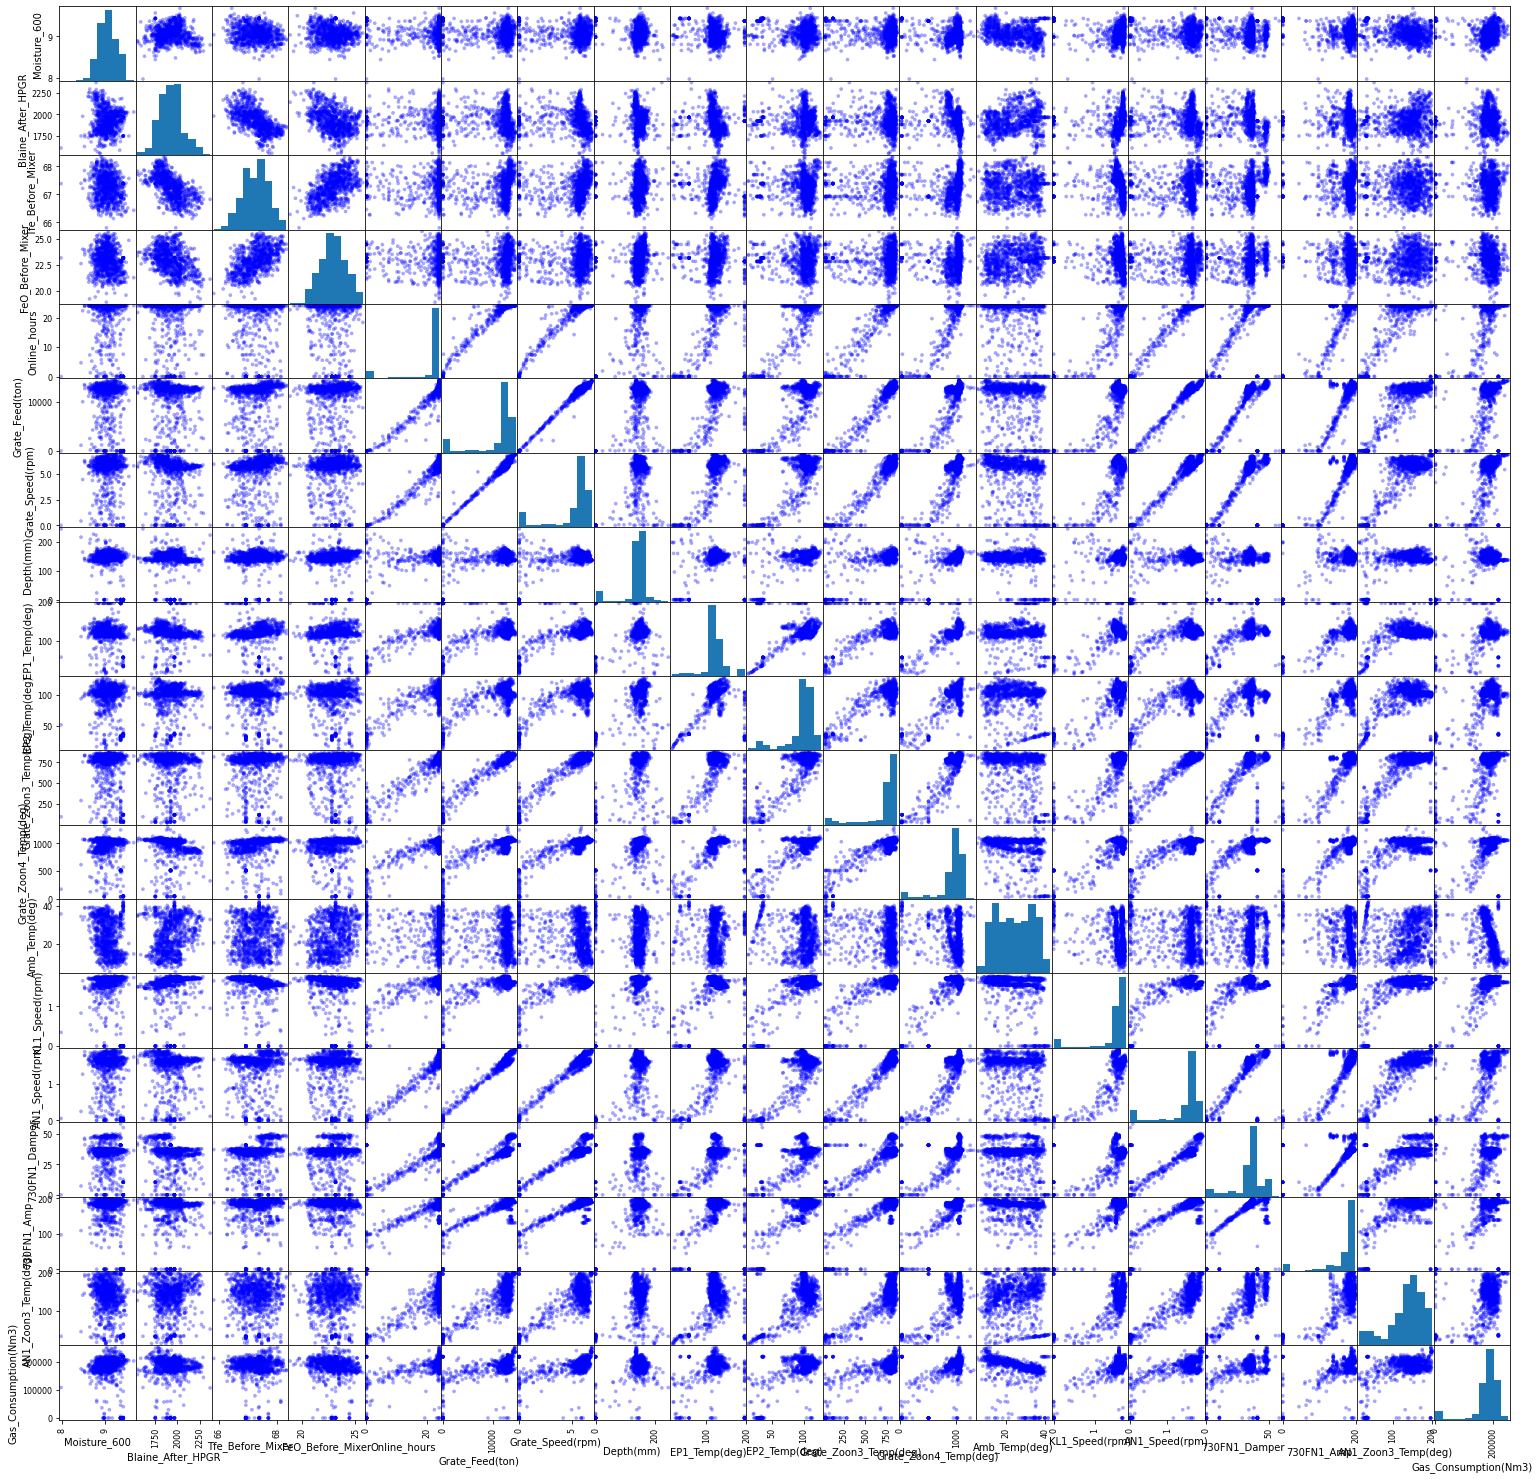

In [5]:
plt.figure(dpi=200)
pd.plotting.scatter_matrix(df, c='blue',alpha=0.35, s=55,figsize=[26,26])
plt.show()

ماتریس ضریب همبستگی دیتاها را محاسبه و ترسیم می کنیم

(19, 19)


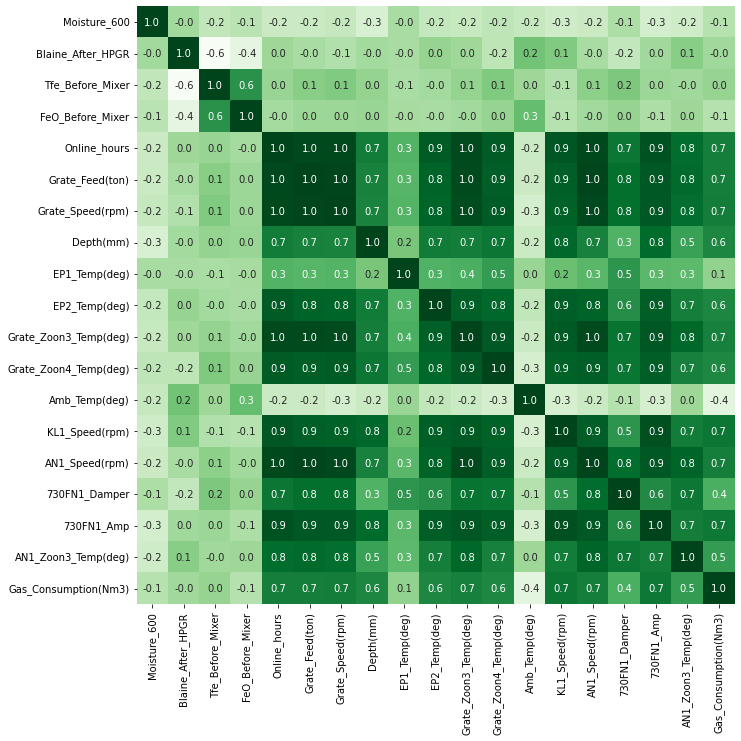

In [6]:
corr = df.corr()
print(corr.shape)
plt.figure(figsize=(11,11))
sns.heatmap(corr, cbar=False,square= True, fmt='.1f', annot=True, annot_kws={'size':10}, cmap='Greens')

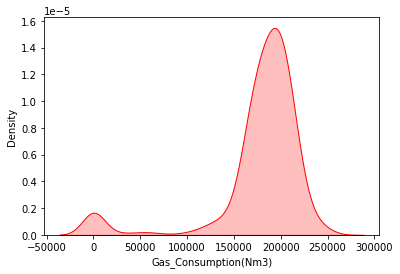

In [37]:
sns.kdeplot(df.iloc[:,18], shade=True , color='r')

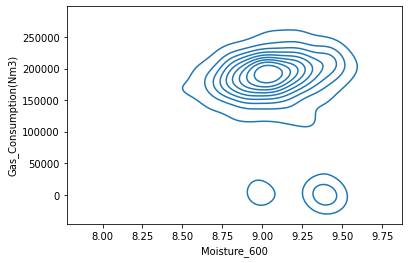

In [39]:
sns.kdeplot(data=df, x=df.iloc[:,0] , y=df.iloc[:,18],)

**مقایسه اثر داده ها **

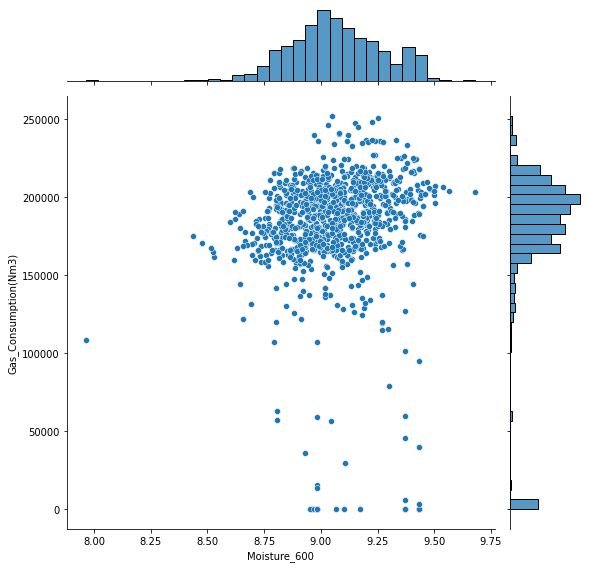

In [11]:
sns.jointplot(x=df.iloc[:,0] , y=df.iloc[:,18], data=df , height=8)

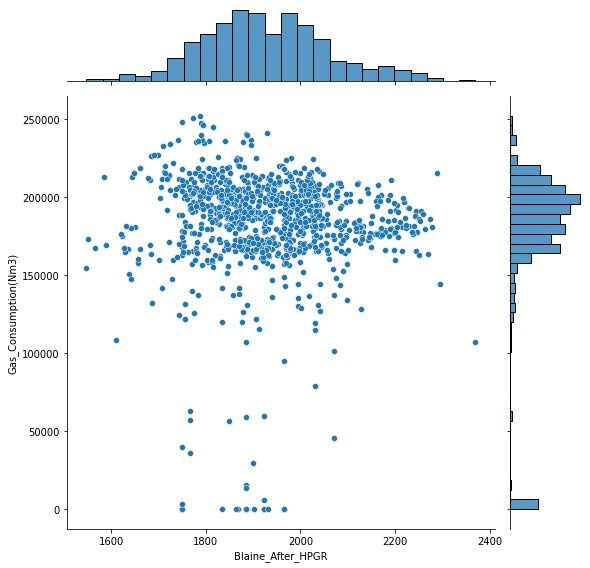

In [17]:
sns.jointplot(x=df.iloc[:,1] , y=df.iloc[:,18], data=df , height=8)

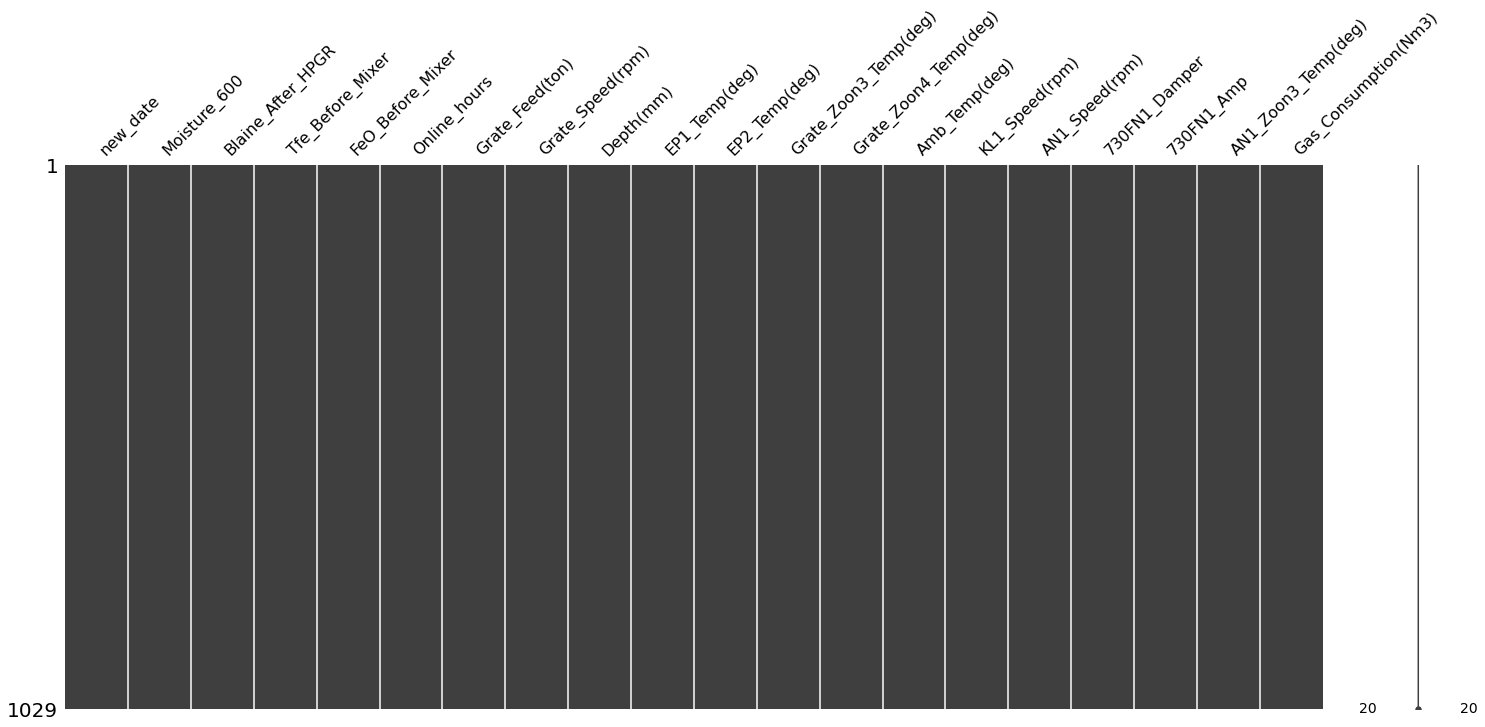

In [ ]:
import missingno as msno
msno.matrix(df) # just to visualize. no missing values.

In [ ]:
# It seems there are no Null Values.
# Let's Confirm
df.isnull().sum()

new_date                 0
Moisture_600             0
Blaine_After_HPGR        0
Tfe_Before_Mixer         0
FeO_Before_Mixer         0
Online_hours             0
Grate_Feed(ton)          0
Grate_Speed(rpm)         0
Depth(mm)                0
EP1_Temp(deg)            0
EP2_Temp(deg)            0
Grate_Zoon3_Temp(deg)    0
Grate_Zoon4_Temp(deg)    0
Amb_Temp(deg)            0
KL1_Speed(rpm)           0
AN1_Speed(rpm)           0
730FN1_Damper            0
730FN1_Amp               0
AN1_Zoon3_Temp(deg)      0
Gas_Consumption(Nm3)     0
dtype: int64

In [ ]:
df.describe()

Moisture_600  ...  Gas_Consumption(Nm3)
count   1029.000000  ...           1029.000000
mean       9.069178  ...         177578.768707
std        0.201084  ...          48448.384062
min        7.966667  ...              0.000000
25%        8.932083  ...         170470.000000
50%        9.059722  ...         188690.000000
75%        9.205000  ...         202352.000000
max        9.681429  ...         252402.000000

[8 rows x 19 columns]

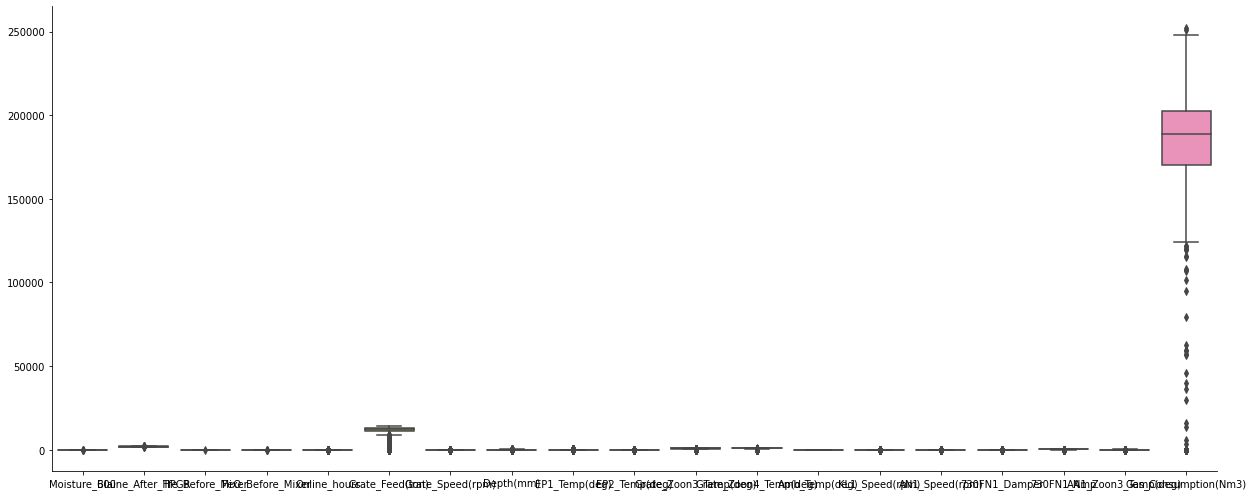

In [ ]:
sns.catplot(data=df, kind='box' , height=7, aspect=2.5)

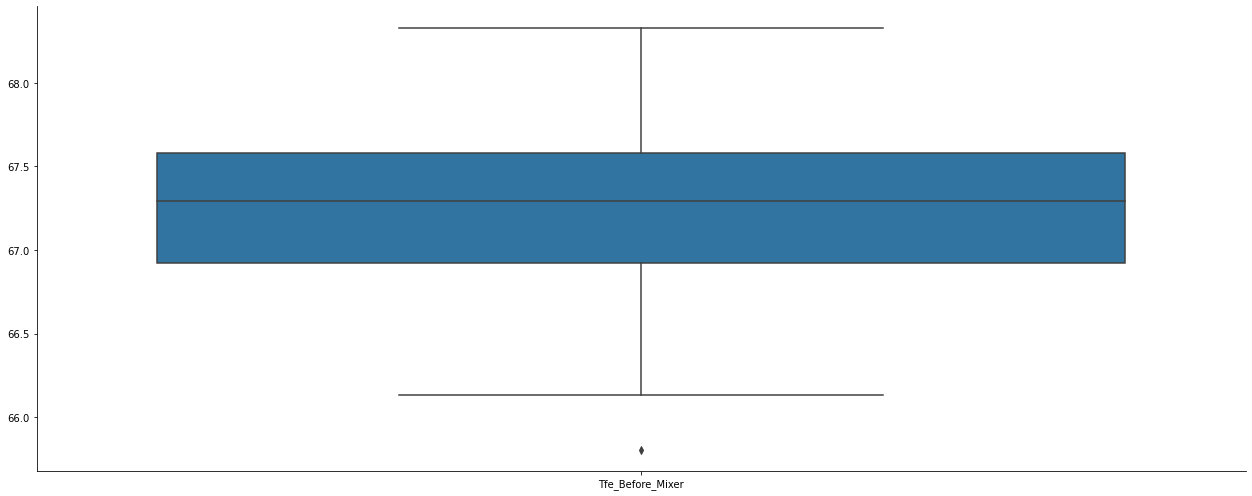

In [ ]:
sns.catplot(data=df.iloc[:,3:4], kind='box' , height=7, aspect=2.5)

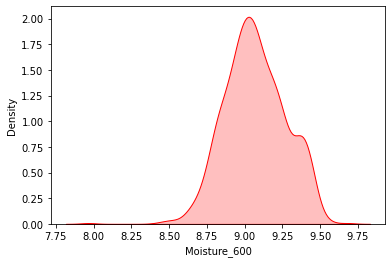

In [ ]:
sns.kdeplot(df.iloc[:,1], shade=True , color='r')

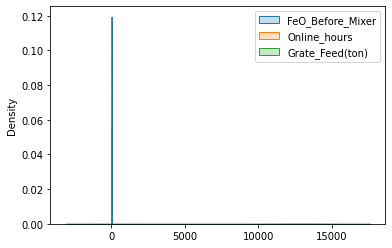

In [ ]:
sns.kdeplot(data=df.iloc[:,4:7],shade=True)

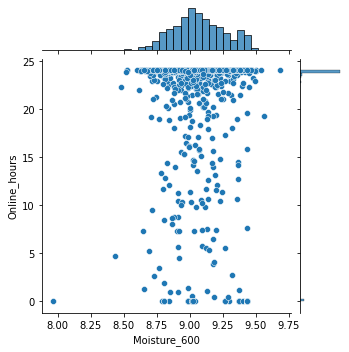

In [ ]:
sns.jointplot(x=df.iloc[:,1] , y=df.iloc[:,5], data=df , height=5)

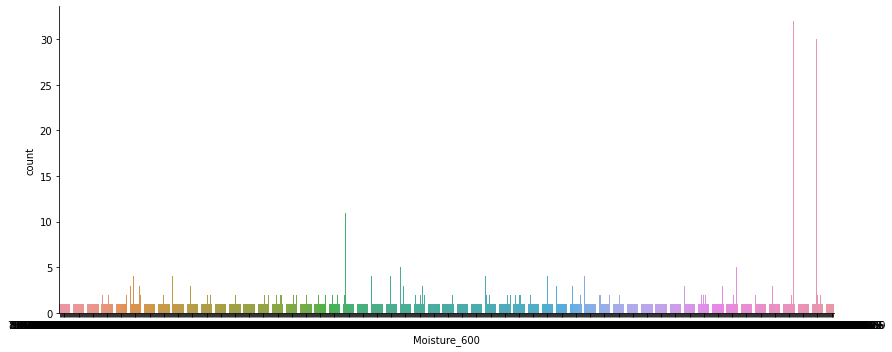

In [ ]:
sns.catplot(x='Moisture_600', data=df , kind='count',aspect=2.5 )

In [ ]:
#sns.catplot(x=df.iloc[:,1], y=df.iloc[:,4] , data=df , kind='violin', aspect=2.5)

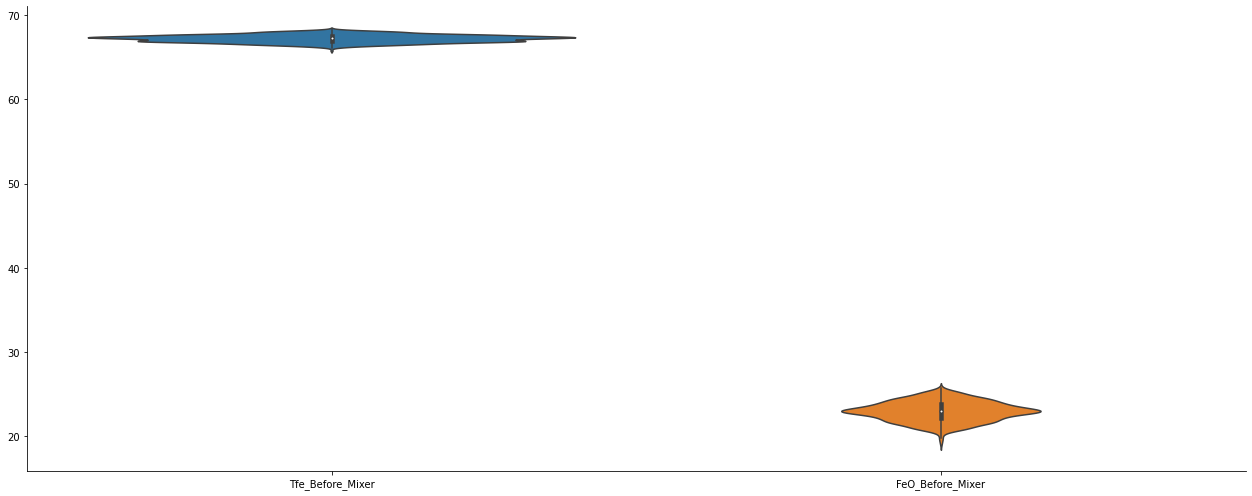

In [ ]:
sns.catplot(data=df.iloc[:,3:5], kind='violin' , height=7, aspect=2.5)

# پالایش داده ها

داده های پرت و نویز را شناسایی و از دیتافریم حذف می کنیم

In [ ]:
col=df.columns
data=df.values
print(data.shape)
print(col)

(1029, 19)
Index(['Moisture_600', 'Blaine_After_HPGR', 'Tfe_Before_Mixer',
       'FeO_Before_Mixer', 'Online_hours', 'Grate_Feed(ton)',
       'Grate_Speed(rpm)', 'Depth(mm)', 'EP1_Temp(deg)', 'EP2_Temp(deg)',
       'Grate_Zoon3_Temp(deg)', 'Grate_Zoon4_Temp(deg)', 'Amb_Temp(deg)',
       'KL1_Speed(rpm)', 'AN1_Speed(rpm)', '730FN1_Damper', '730FN1_Amp',
       'AN1_Zoon3_Temp(deg)', 'Gas_Consumption(Nm3)'],
      dtype='object')


In [ ]:
# identify outliers in the dataset
iso = IsolationForest()
yhat = iso.fit_predict(data)

In [ ]:
print(yhat.shape)

(1029,)


In [ ]:
# select all rows that are not outliers
mask = yhat != -1

In [ ]:
mask

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
data = data[mask, :]

In [ ]:
data.shape

(853, 19)

In [ ]:
not_outliers_df=pd.DataFrame(data,columns=col)

In [ ]:
not_outliers_df

Moisture_600  Blaine_After_HPGR  ...  AN1_Zoon3_Temp(deg)  Gas_Consumption(Nm3)
0        9.068056        1944.333333  ...           141.628364              196364.0
1        8.997183        2014.000000  ...           145.570481              209304.0
2        8.795833        2036.909091  ...           173.127236              206200.0
3        8.850536        2028.555556  ...           179.281210              203772.0
4        9.006061        2034.181818  ...           129.430960              200120.0
..            ...                ...  ...                  ...                   ...
848      8.986111        1840.727273  ...           199.714990              236188.0
849      9.172222        1835.181818  ...           191.140781              217142.0
850      9.094444        1833.250000  ...           191.140781              216634.0
851      9.104167        1833.250000  ...           191.140781              213588.0
852      9.104167        1833.250000  ...           191.140781              212952.0

[853 rows x 19 columns]

<Figure size 1200x800 with 0 Axes>

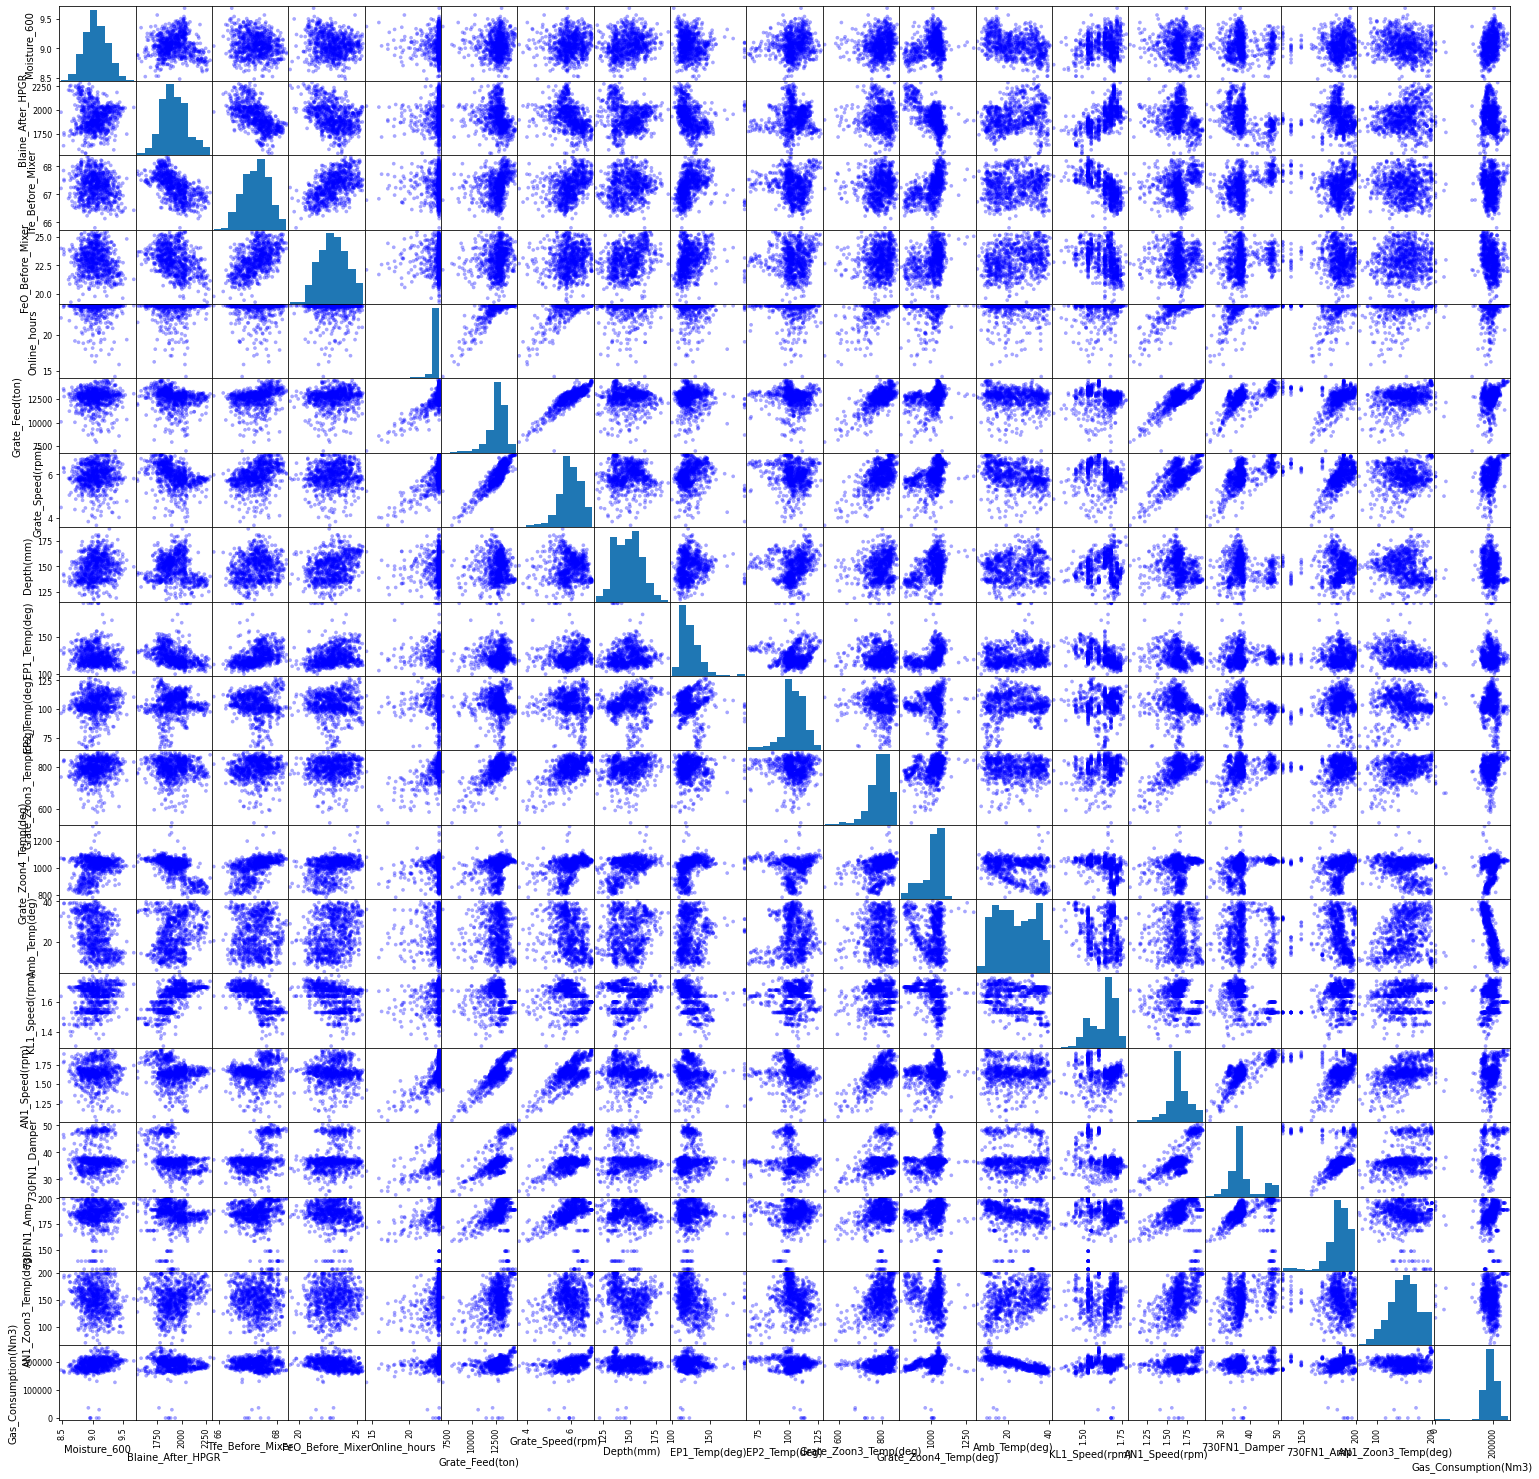

In [ ]:
plt.figure(dpi=200)
pd.plotting.scatter_matrix(not_outliers_df, c='blue',alpha=0.35, s=55,figsize=[26,26])
plt.show()

(19, 19)


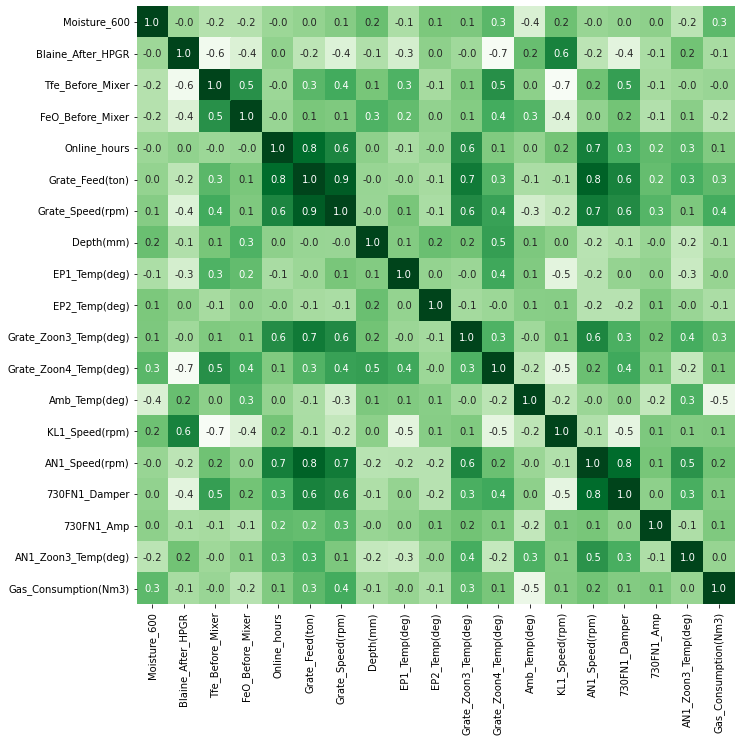

In [ ]:
corr = not_outliers_df.corr()
print(corr.shape)
plt.figure(figsize=(11,11))
sns.heatmap(corr, cbar=False,square= True, fmt='.1f', annot=True, annot_kws={'size':10}, cmap='Greens')

# نرمالسازی داده ها

In [ ]:
data=normalize(data,norm='l2',axis=0)

In [ ]:
normal_df=pd.DataFrame(data,columns=col)

In [ ]:
normal_df

Moisture_600  Blaine_After_HPGR  ...  AN1_Zoon3_Temp(deg)  Gas_Consumption(Nm3)
0        0.034291           0.034490  ...             0.031824              0.034963
1        0.034023           0.035726  ...             0.032709              0.037267
2        0.033262           0.036132  ...             0.038901              0.036714
3        0.033469           0.035984  ...             0.040284              0.036282
4        0.034057           0.036084  ...             0.029083              0.035632
..            ...                ...  ...                  ...                   ...
848      0.033981           0.032652  ...             0.044876              0.042054
849      0.034685           0.032554  ...             0.042949              0.038663
850      0.034391           0.032519  ...             0.042949              0.038572
851      0.034428           0.032519  ...             0.042949              0.038030
852      0.034428           0.032519  ...             0.042949              0.037917

[853 rows x 19 columns]

<Figure size 1200x800 with 0 Axes>

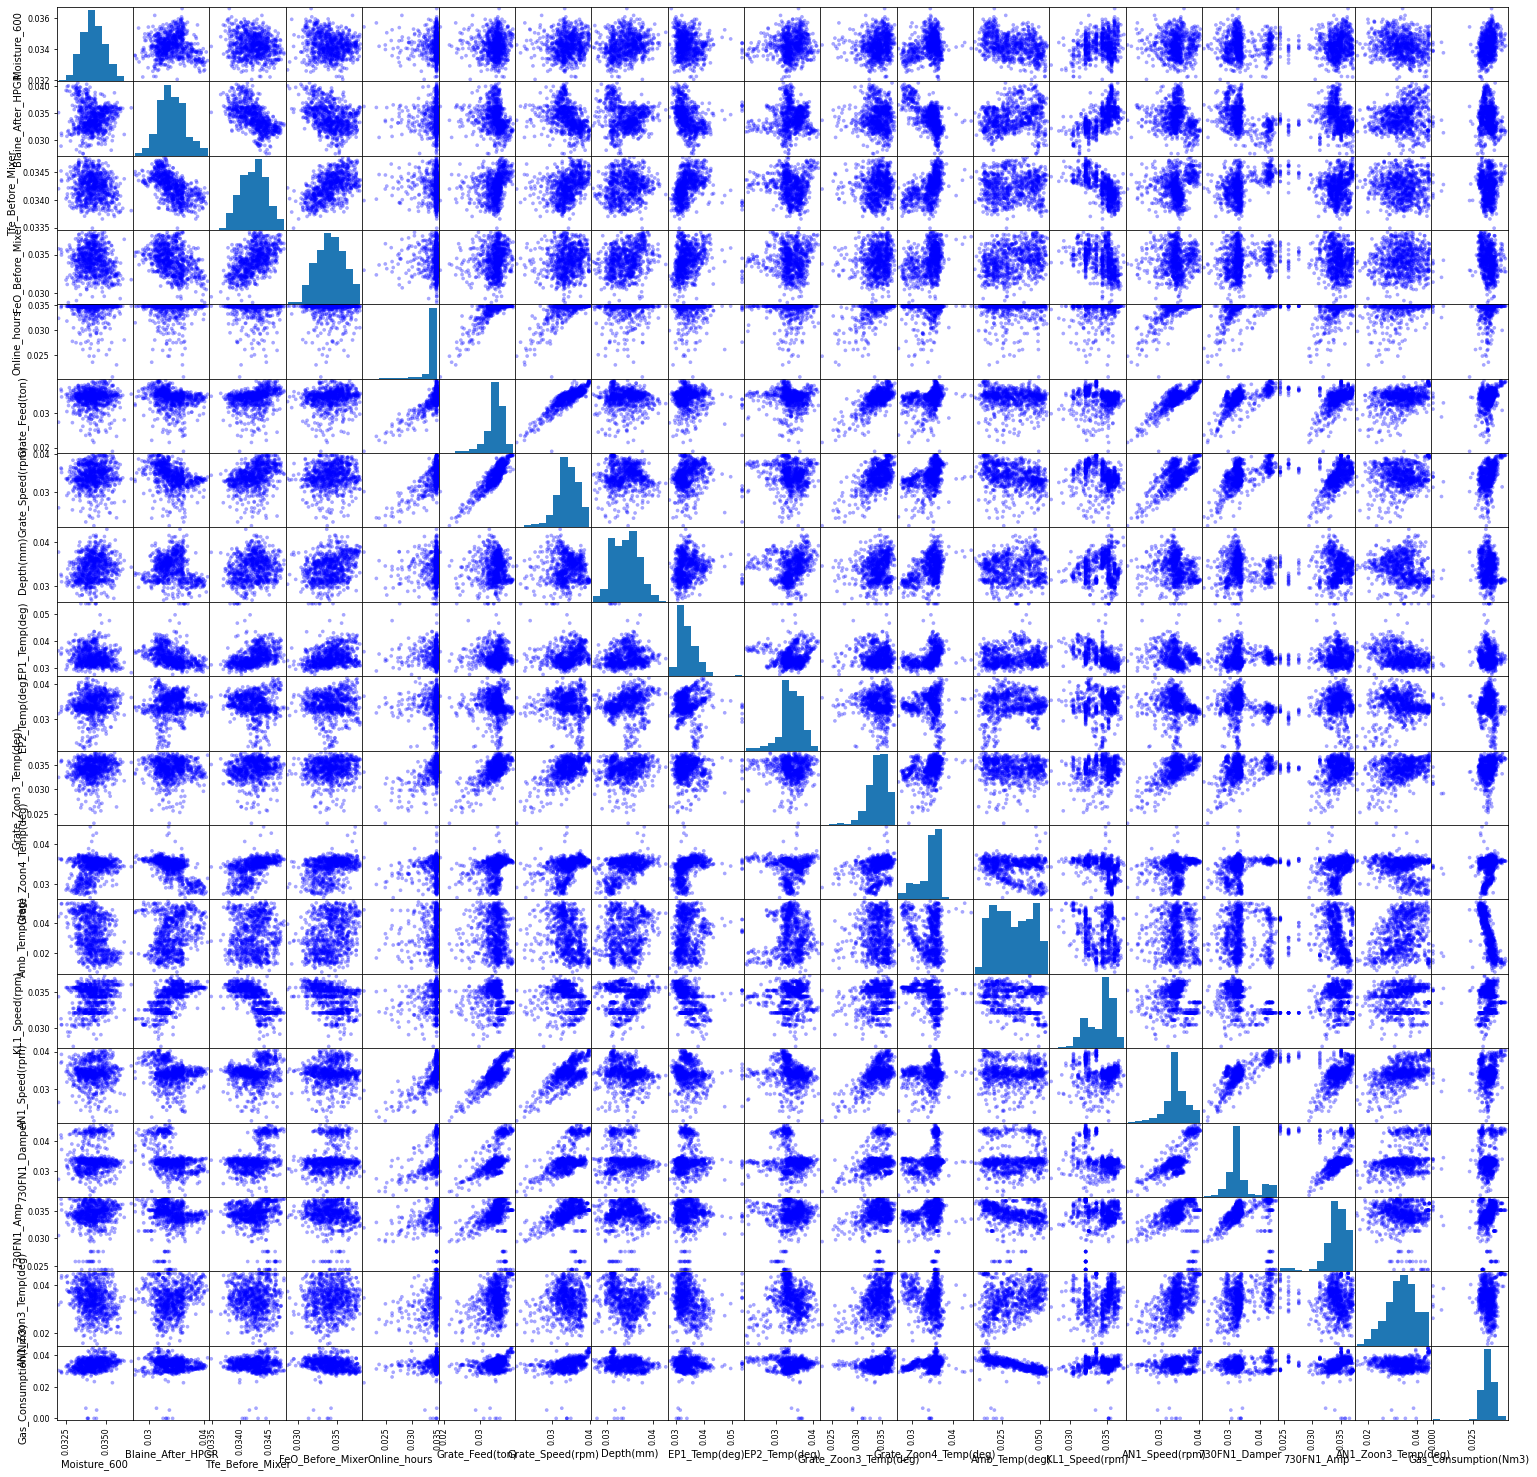

In [ ]:
plt.figure(dpi=200)
pd.plotting.scatter_matrix(normal_df, c='blue',alpha=0.35, s=55,figsize=[26,26])
plt.show()

(19, 19)


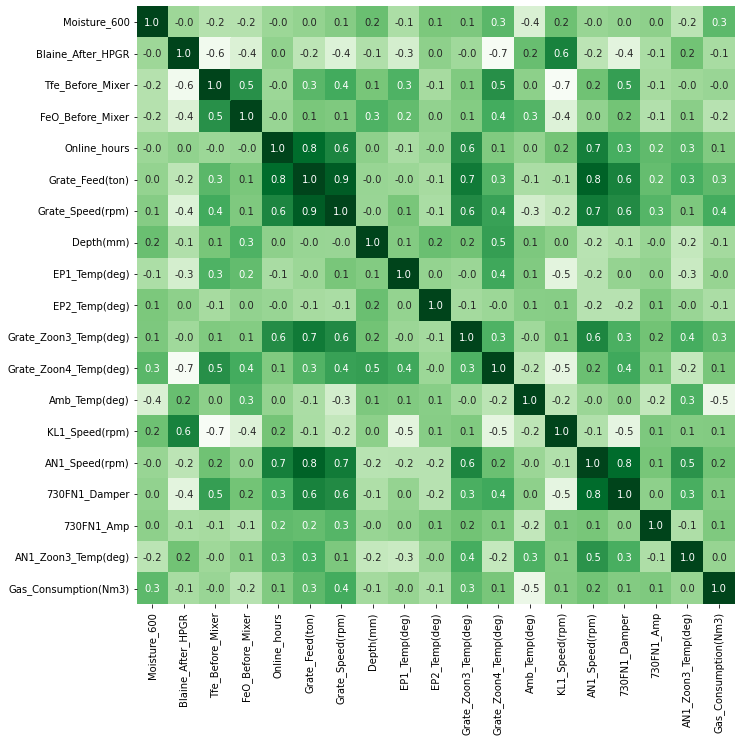

In [ ]:
corr = normal_df.corr()
print(corr.shape)
plt.figure(figsize=(11,11))
sns.heatmap(corr, cbar=False,square= True, fmt='.1f', annot=True, annot_kws={'size':10}, cmap='Greens')

# جداسازی داده های آموزشی و تست

In [ ]:
# split into input and output elements
X, y = data[:, :-1], data[:, -1]

In [ ]:
X

array([[0.0342911 , 0.03448997, 0.03406758, ..., 0.02986466, 0.03438547,
        0.0318236 ],
       [0.03402309, 0.03572577, 0.03403195, ..., 0.02929954, 0.03416778,
        0.03270939],
       [0.03326168, 0.03613215, 0.03403195, ..., 0.02881311, 0.0335617 ,
        0.03890134],
       ...,
       [0.03439089, 0.0325195 , 0.03445434, ..., 0.04407765, 0.03630107,
        0.04294894],
       [0.03442766, 0.0325195 , 0.034473  , ..., 0.04322186, 0.03630107,
        0.04294894],
       [0.03442766, 0.0325195 , 0.034473  , ..., 0.03755627, 0.03630107,
        0.04294894]])

In [ ]:
y

array([0.03496309, 0.03726709, 0.03671442, 0.03628211, 0.03563186,
       0.03723148, 0.03585977, 0.03684475, 0.03614892, 0.03615889,
       0.03503645, 0.03542959, 0.03420459, 0.03561548, 0.03557702,
       0.03595164, 0.0366667 , 0.02924903, 0.03720014, 0.03604921,
       0.03597372, 0.03688606, 0.03582985, 0.03651927, 0.03511266,
       0.035191  , 0.03582131, 0.03728347, 0.03552859, 0.0352316 ,
       0.03582629, 0.03716382, 0.03535125, 0.03700642, 0.03841802,
       0.03761465, 0.03566462, 0.03523516, 0.03466396, 0.03251523,
       0.03192481, 0.03317117, 0.03223747, 0.03108653, 0.03306007,
       0.03120619, 0.03170758, 0.03157084, 0.03178664, 0.03105662,
       0.03037219, 0.03210286, 0.03122328, 0.03093127, 0.03085293,
       0.03163636, 0.0320238 , 0.03406215, 0.03506209, 0.03434703,
       0.03435985, 0.03346389, 0.03403366, 0.03368468, 0.03559126,
       0.03410844, 0.03422097, 0.0347124 , 0.03498944, 0.03394891,
       0.03311705, 0.03316191, 0.03323456, 0.03279513, 0.03236

In [ ]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_test.shape,X_train.shape)

(256, 18) (597, 18)


# استفاده از مدل رگرسیون خطی برای حل مسئله و حدس زدن جواب نمونه های آزمایشی

In [ ]:
# fit the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

مدل چقدر خوب آموزش دیده است؟

In [ ]:
ybar = model.predict(X_train)

In [ ]:
# evaluate predictions
mae = mean_absolute_error(y_train, ybar)
print('MAE: %.3f' %mae)

MAE: 0.001


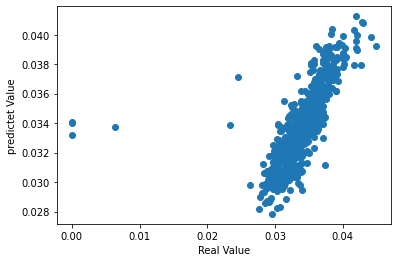

In [ ]:
plt.scatter(y_train, ybar)
plt.xlabel('Real Value')
plt.ylabel('predictet Value')
plt.show()

In [ ]:
print("The Train Score is ", (r2_score( y_train, ybar)))

The Train Score is  0.4301257542203194


مدل چقدر خوب حدس می زند؟

In [ ]:
# evaluate the model
yhat = model.predict(X_test)

In [ ]:
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' %mae)

MAE: 0.002


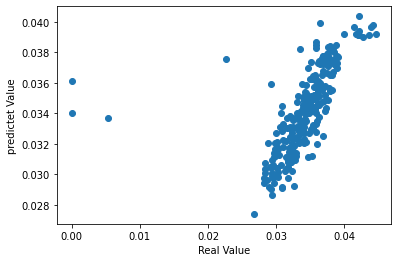

In [ ]:
plt.scatter(y_test,yhat)
plt.xlabel('Real Value')
plt.ylabel('predictet Value')
plt.show()

In [ ]:
print("The Predict Score is ", (r2_score( y_test,yhat)))


The Predict Score is  0.3011774355264626


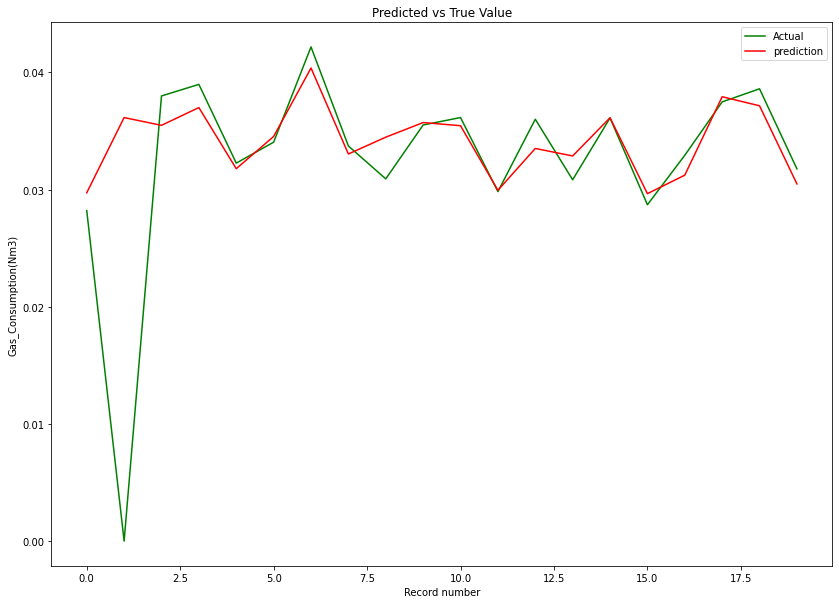

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(range(20),y_test[0:20], color = "green")
plt.plot(range(20),model.predict(X_test[0:20]), color = "red")
plt.legend(["Actual","prediction"]) 
plt.title("Predicted vs True Value")
plt.xlabel("Record number")
plt.ylabel(col[-1])
plt.show()

# استفاده از شبکه عصبی برای حل مسئله و حدس زدن جواب نمونه های آزمایشی

In [ ]:
model = MLPRegressor(hidden_layer_sizes=(100,),activation="relu" ,random_state=1, max_iter=200000)
model.fit(X_train, y_train)


MLPRegressor(max_iter=200000, random_state=1)

مدل چقدر خوب آموزش دیده است؟

In [ ]:
ybar = model.predict(X_train)

In [ ]:
# evaluate predictions
mae = mean_absolute_error(y_train, ybar)
print('MAE: %.3f' %mae)

MAE: 0.003


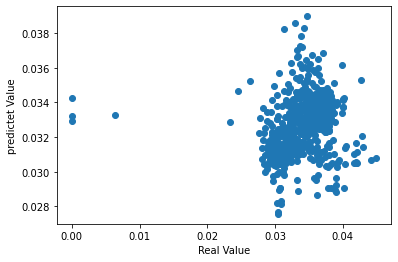

In [ ]:
plt.scatter(y_train, ybar)
plt.xlabel('Real Value')
plt.ylabel('predictet Value')
plt.show()

In [ ]:
print("The Train Score is ", (r2_score( y_train, ybar)))

The Train Score is  -0.1713482440721712


مدل چقدر خوب حدس می زند؟

In [ ]:
# evaluate the model
yhat = model.predict(X_test)

In [ ]:
print("The Train Score is: ", (r2_score( y_test,yhat)))

The Train Score is:  -0.21307614936408203


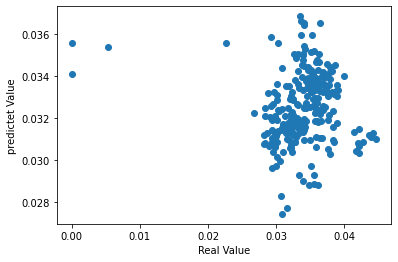

In [ ]:
plt.scatter(y_test,yhat)
plt.xlabel('Real Value')
plt.ylabel('predictet Value')
plt.show()

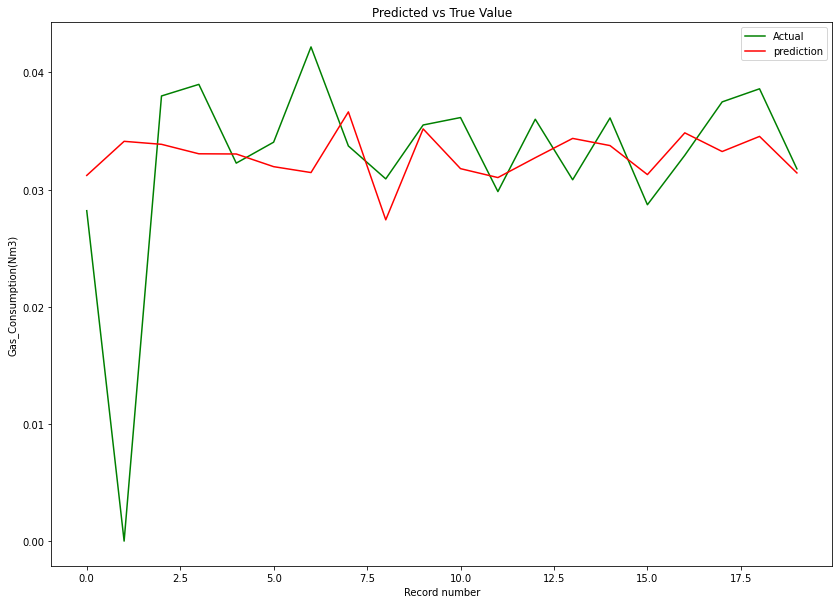

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(range(20),y_test[0:20], color = "green")
plt.plot(range(20),model.predict(X_test[0:20]), color = "red")
plt.legend(["Actual","prediction"]) 
plt.title("Predicted vs True Value")
plt.xlabel("Record number")
plt.ylabel(col[-1])
plt.show()

# Decision Tree Regression

In [ ]:
model = DecisionTreeRegressor(random_state=123)
model = model.fit(X_train,y_train)

In [ ]:
print("Accuracy on test: {:.2f} %".format(model.score(X_test, y_test)*100))

Accuracy on test: 8.74 %


In [ ]:
y_pred = model.predict(X_test)
print("R2 Score: {:.2f}%".format(r2_score(y_test,y_pred)*100))
print("Mean Absolute Error {:.2f}".format(mean_absolute_error(y_test,y_pred)))
print("Mean Squared Error {:.2f}".format(mean_squared_error(y_test,y_pred)))

R2 Score: 8.74%
Mean Absolute Error 0.00
Mean Squared Error 0.00


In [ ]:
model.feature_importances_

array([0.00130683, 0.03601519, 0.00807704, 0.00575637, 0.00141128,
       0.11850889, 0.24059144, 0.13200637, 0.01063207, 0.01346613,
       0.03128949, 0.00926153, 0.3126868 , 0.00142633, 0.05476939,
       0.01018254, 0.00288842, 0.0097239 ])

(-1.0, 18.0)

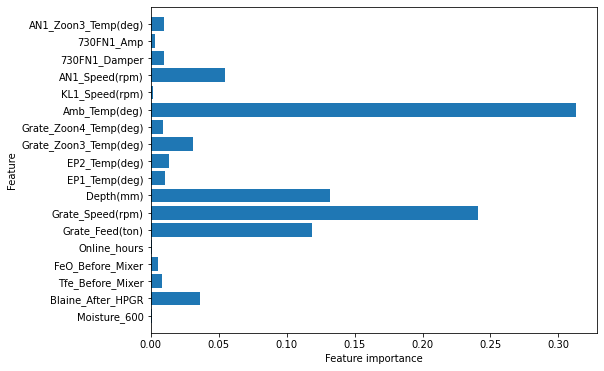

In [ ]:
plt.figure(figsize=(8,6))
n_features = len(col)-1
plt.barh(range(n_features), model.feature_importances_, align='center')
plt.yticks(np.arange(len(col)-1), col[:-1])
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)

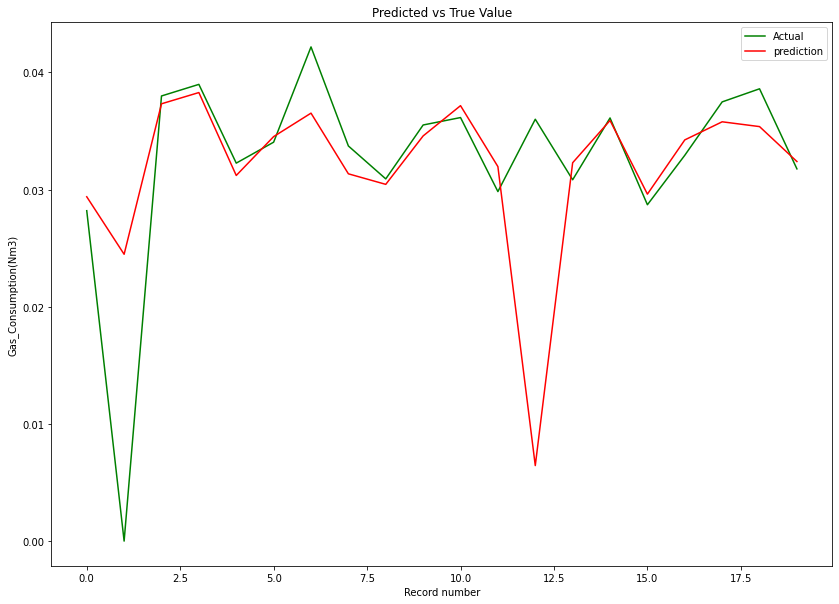

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(range(20),y_test[0:20], color = "green")
plt.plot(range(20),model.predict(X_test[0:20]), color = "red")
plt.legend(["Actual","prediction"]) 
plt.title("Predicted vs True Value")
plt.xlabel("Record number")
plt.ylabel(col[-1])
plt.show()

# Support Vector Regression

In [ ]:
model=SVR()
model.fit(X_train,y_train)

SVR()

In [ ]:
print("Accuracy score {:.2f} %\n".format(model.score(X_test,y_test)*100))

Accuracy score -551.87 %



In [ ]:
y_pred = model.predict(X_test)
print("R2 Score: {:.2f}%".format(r2_score(y_test,y_pred)*100))
print("Mean Absolute Error {:.2f}".format(mean_absolute_error(y_test,y_pred)))
print("Mean Squared Error {:.2f}".format(mean_squared_error(y_test,y_pred)))

R2 Score: -551.87%
Mean Absolute Error 0.01
Mean Squared Error 0.00


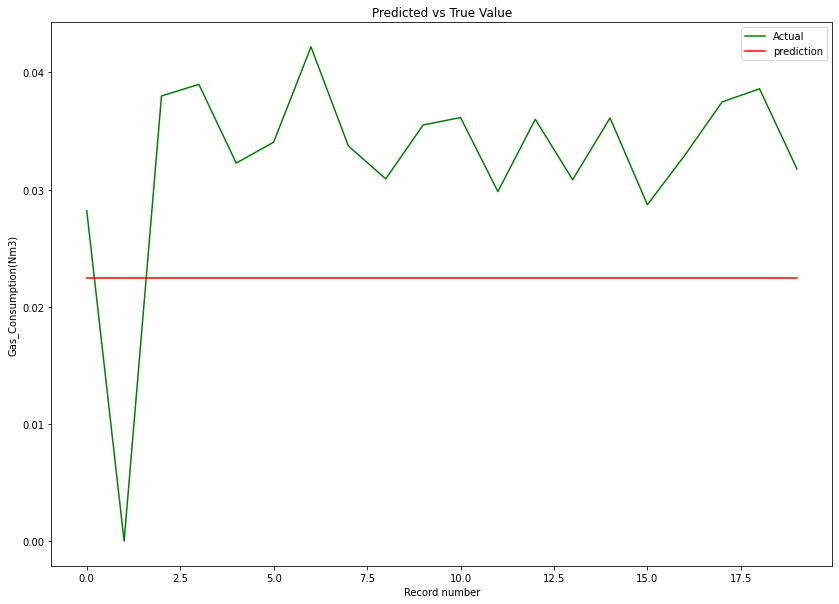

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(range(20),y_test[0:20], color = "green")
plt.plot(range(20),model.predict(X_test[0:20]), color = "red")
plt.legend(["Actual","prediction"]) 
plt.title("Predicted vs True Value")
plt.xlabel("Record number")
plt.ylabel(col[-1])
plt.show()

# K-Nearest Neighbor Regressor

In [ ]:
model=KNeighborsRegressor(n_jobs=-1)
model.fit(X_train,y_train)

KNeighborsRegressor(n_jobs=-1)

In [ ]:
print("Accuracy score {:.2f} %\n".format(model.score(X_test,y_test)*100))

Accuracy score 45.74 %



In [ ]:
y_pred = model.predict(X_test)
print("R2 Score: {:.2f}%".format(r2_score(y_test,y_pred)*100))
print("Mean Absolute Error {:.2f}".format(mean_absolute_error(y_test,y_pred)))
print("Mean Squared Error {:.2f}".format(mean_squared_error(y_test,y_pred)))

R2 Score: 45.74%
Mean Absolute Error 0.00
Mean Squared Error 0.00


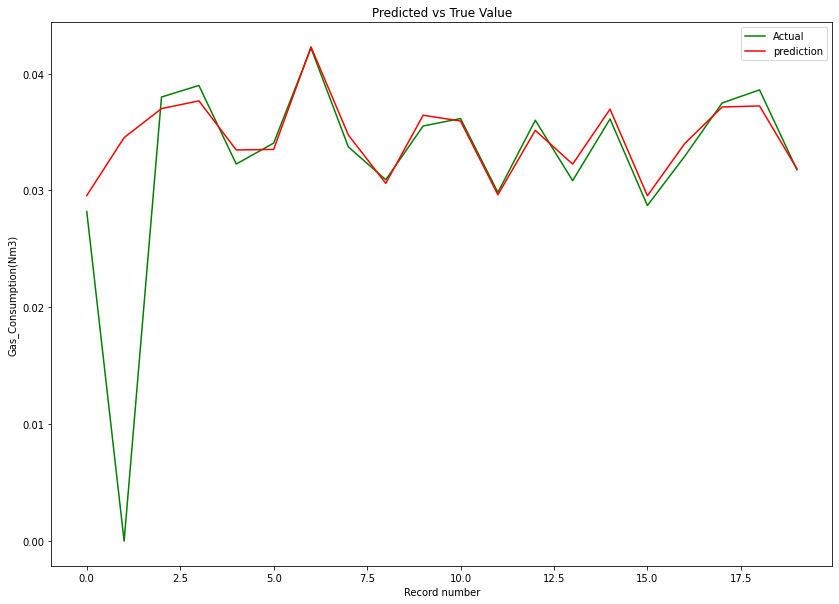

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(range(20),y_test[0:20], color = "green")
plt.plot(range(20),model.predict(X_test[0:20]), color = "red")
plt.legend(["Actual","prediction"]) 
plt.title("Predicted vs True Value")
plt.xlabel("Record number")
plt.ylabel(col[-1])
plt.show()

# Random Forest Regressor

In [ ]:
model = RandomForestRegressor(n_jobs = -1,random_state = 123)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=123)

In [ ]:
print("Accuracy score {:.2f} %\n".format(model.score(X_test,y_test)*100))

Accuracy score 39.64 %



In [ ]:
y_pred = model.predict(X_test)
print("R2 Score: {:.2f}%".format(r2_score(y_test,y_pred)*100))
print("Mean Absolute Error {:.2f}".format(mean_absolute_error(y_test,y_pred)))
print("Mean Squared Error {:.2f}".format(mean_squared_error(y_test,y_pred)))

R2 Score: 39.64%
Mean Absolute Error 0.00
Mean Squared Error 0.00


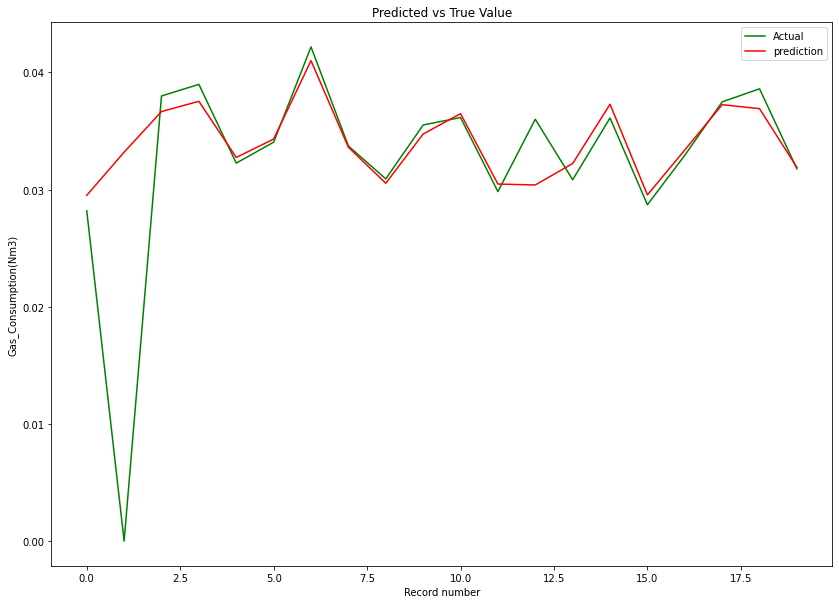

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(range(20),y_test[0:20], color = "green")
plt.plot(range(20),model.predict(X_test[0:20]), color = "red")
plt.legend(["Actual","prediction"]) 
plt.title("Predicted vs True Value")
plt.xlabel("Record number")
plt.ylabel(col[-1])
plt.show()

(-1.0, 18.0)

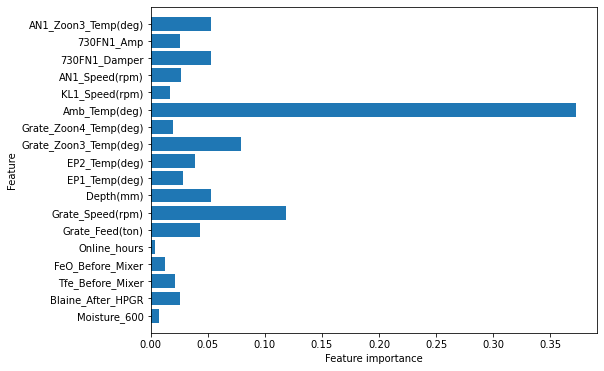

In [ ]:
plt.figure(figsize=(8,6))
n_features = len(col)-1
plt.barh(range(n_features), model.feature_importances_, align='center')
plt.yticks(np.arange(len(col)-1), col[:-1])
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)

# Gradient Boosting Regressor

In [ ]:
model = GradientBoostingRegressor(random_state = 123)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=123)

In [ ]:
print("Accuracy score {:.2f} %\n".format(model.score(X_test,y_test)*100))

Accuracy score 35.71 %



In [ ]:
y_pred = model.predict(X_test)
print("R2 Score: {:.2f}%".format(r2_score(y_test,y_pred)*100))
print("Mean Absolute Error {:.2f}".format(mean_absolute_error(y_test,y_pred)))
print("Mean Squared Error {:.2f}".format(mean_squared_error(y_test,y_pred)))

R2 Score: 35.71%
Mean Absolute Error 0.00
Mean Squared Error 0.00


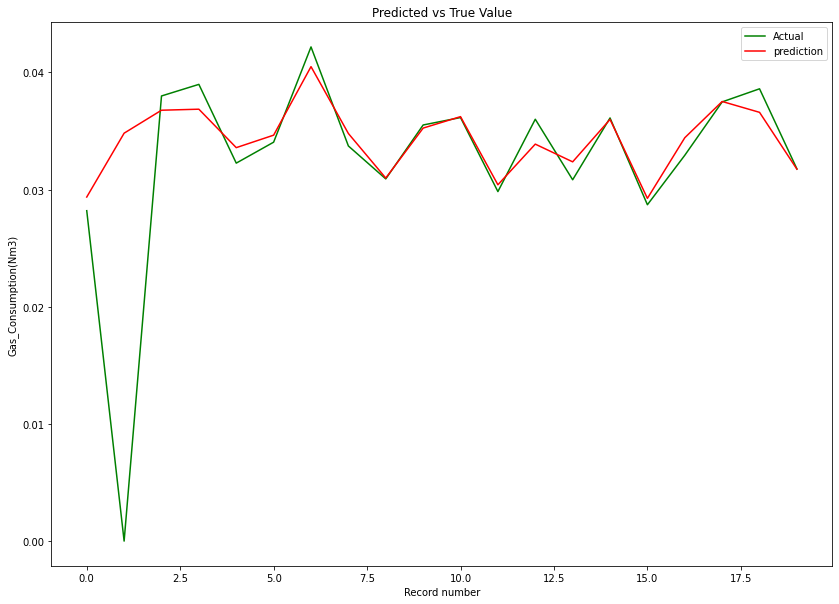

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(range(20),y_test[0:20], color = "green")
plt.plot(range(20),model.predict(X_test[0:20]), color = "red")
plt.legend(["Actual","prediction"]) 
plt.title("Predicted vs True Value")
plt.xlabel("Record number")
plt.ylabel(col[-1])
plt.show()

(-1.0, 18.0)

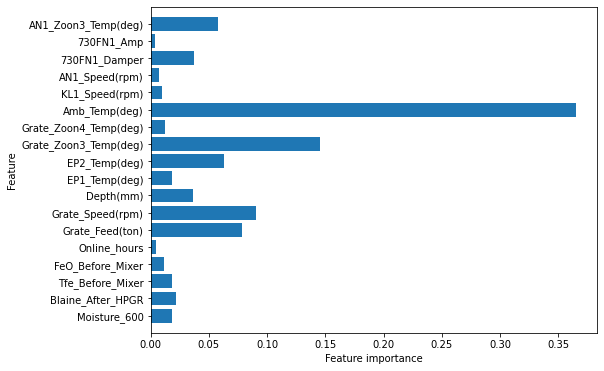

In [ ]:
plt.figure(figsize=(8,6))
n_features = len(col)-1
plt.barh(range(n_features), model.feature_importances_, align='center')
plt.yticks(np.arange(len(col)-1), col[:-1])
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)

# Extreme Gradient Boosting Regressor

In [ ]:
model = XGBRegressor(random_state = 123,n_jobs=-1)
model.fit(X_train, y_train)

[11:10:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_jobs=-1, random_state=123)

In [ ]:
print("Accuracy score {:.2f} %\n".format(model.score(X_test,y_test)*100))

Accuracy score 40.99 %



In [ ]:
y_pred = model.predict(X_test)
print("R2 Score: {:.2f}%".format(r2_score(y_test,y_pred)*100))
print("Mean Absolute Error {:.2f}".format(mean_absolute_error(y_test,y_pred)))
print("Mean Squared Error {:.2f}".format(mean_squared_error(y_test,y_pred)))

R2 Score: 40.99%
Mean Absolute Error 0.00
Mean Squared Error 0.00


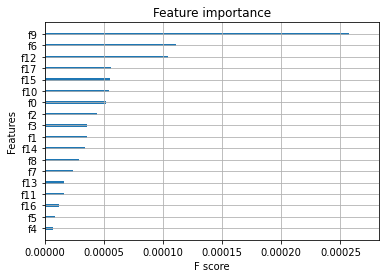

In [ ]:
xgb.plot_importance(model,importance_type="gain",show_values=False)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

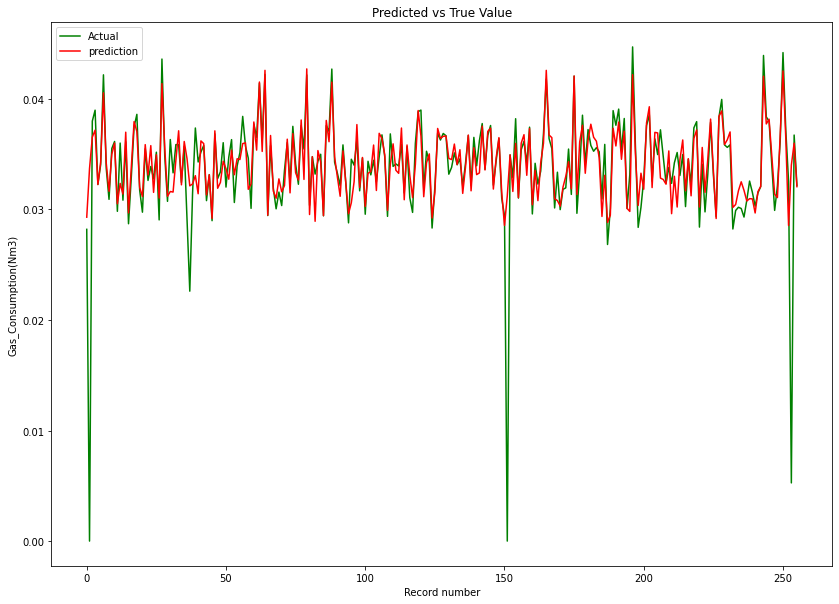

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(range(256),y_test[0:256], color = "green")
plt.plot(range(256),model.predict(X_test[0:256]), color = "red")
plt.legend(["Actual","prediction"]) 
plt.title("Predicted vs True Value")
plt.xlabel("Record number")
plt.ylabel(col[-1])
plt.show()